In [27]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode

load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools=tools)

def model(state: AgentState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

def tools_router(state: AgentState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    

tool_node = ToolNode(tools=tools)

graph = StateGraph(AgentState)

graph.add_node("model", model)
graph.add_node("tool_node", tool_node)
graph.set_entry_point("model")

graph.add_conditional_edges("model", tools_router, {"tool_node": "tool_node", END: END})
graph.add_edge("tool_node", "model")

app = graph.compile()

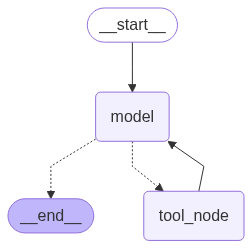

In [28]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [25]:
input = {
    "messages": ["What's the current weather in Vaasa?"]
}
# "stream-mode='values'-  "stream_mode:'values'-"
# {"messages":["a"]}"      {"messages":["a"]}
# {"messages":["b"]}"      {"messages":["a", "b"]}
# {"messages":["c"]}"      {"messages":["a","b","c"]}
events = app.stream(input=input, stream_mode="values")

for event in events: 
    print(event["messages"])

[HumanMessage(content="What's the current weather in Vaasa?", additional_kwargs={}, response_metadata={}, id='3c5f273b-1be3-4089-9c08-ab13ea11d0aa')]
[HumanMessage(content="What's the current weather in Vaasa?", additional_kwargs={}, response_metadata={}, id='3c5f273b-1be3-4089-9c08-ab13ea11d0aa'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3Mm3vfYWILEJ8eiwNMejBhkR', 'function': {'arguments': '{"query":"current weather in Vaasa"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 87, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BdjH61b4qR6rI29Sga9cbfgDFNuEl', 'service_tier': 'default', 'f

In [26]:
input = {
    "messages": ["What's the current weather in Vaasa?"]
}

events = app.stream(input=input, stream_mode="updates")

for event in events: 
    print(event)

{'model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jrOuXGR3tVdnNrk53zOzC81y', 'function': {'arguments': '{"query":"current weather in Vaasa"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 87, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BdjHLiiBPP50AaKzp9080zVoDI7c2', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f7bee7d5-43a4-4b86-800a-bb9fd9781695-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Vaasa'}, 'id': 'call_jrOuXGR3tVdnNrk53zOzC81y', 'type': 'tool_call'}], usage_metadata={'i

In [30]:
input = {
    "messages": ["How are you doing body?"]
}

events = app.astream_events(input=input, version="v2")

async for event in events: 
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['How are you doing body?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '70a677b5-7d9b-4574-ba1f-49e693f9c4bd', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='How are you doing body?', additional_kwargs={}, response_metadata={}, id='d287e01f-c3cd-4897-8020-5884d1f796e6')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '9e35686a-3da7-4464-8224-1ec2857e0f03', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:426b543d-17b6-8480-157a-e860352b638e'}, 'parent_ids': ['70a677b5-7d9b-4574-ba1f-49e693f9c4bd']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='How are you doing body?', additional_kwargs={}, response_metadata={}, id='d287e01f-c3cd-4897-8020-5884d1f796e6')]]}}, 'name': 'ChatO

In [ ]:
input = {
    "messages": ["How are you doing body?"]
}

events = app.astream_events(input=input, version="v2")

async for event in events: 
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?

: 